# Introduction

The notebook is intended to experiment with Convolutional Neural Network in PyTorch.

In [1]:
# Import Standard Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

/Users/s.porreca/.local/share/virtualenvs/cheat_sheets-EiW5VkhA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

# Data Preparation

In [3]:
# Define the mean and std of the MNIST dataset for the data normalisation
# NOTE: We are not going to compute them
mean = 0.1307
std = 0.3081

In [4]:
# Define the a set of data transformation through the function "compose"
data_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

In [5]:
# Load the MNIST dataset
train_data = datasets.MNIST(root='./../../data', 
                            train=True, 
                            transform=data_transformations, 
                            download=True)

test_data = datasets.MNIST(root='./../../data',
                           train=False,
                           transform=data_transformations)

In [6]:
# Define a DataLoader for batch training & testing
train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                batch_size=100, 
                                                shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_data, 
                                               batch_size=100, 
                                               shuffle=False)

# Plot Sample Data

In [7]:
# Retrieve an image and normalise it
image = train_data[20][0].numpy() * mean * std

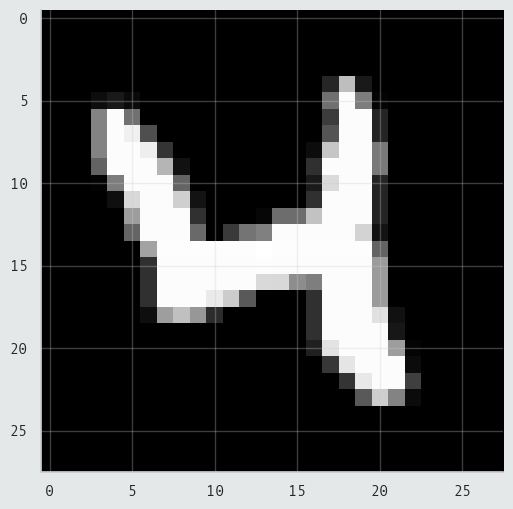

In [8]:
# Show the image
# NOTE: It needs to be reshaped to N x N dimension from a 3-Channel
_ = plt.imshow(image.reshape(28, 28),
               cmap='gray') # Define image gray color

# Model Definition

## Define the Neural Network

In [9]:
class Model(nn.Module):
    
    """
    Initialise a Convolutional Neural Network

    Attributes:
        conv2d_1 nn.Conv2d Convolutional 2-D Layer 1 

    """
    
    def __init__(self, 
                 conv2d_1_attributes: dict, 
                 batch_normalisation_1_attributes: dict, 
                 max_pooling_1_attributes: dict, 
                 conv2d_2_attributes: dict, 
                 batch_normalisation_2_attributes: dict, 
                 max_pooling_2_attributes: dict):
    
        """
        Initialise the Neural Network

        Args:
            conv2d_1_attributes Dictionary of conv2d_1 attributes
            batch_normalisation_1_attributes Dictionary of batch_normalisation_1 attributes
            max_pooling_1_attributes Dictionary of max_pooling_1 attributes
            conv2d_2_attributes Dictionary of conv2d_1 attributes
            batch_normalisation_2_attributes Dictionary of batch_normalisation_2 attributes
            max_pooling_2_attributes Dictionary of max_pooling_2 attributes

        """

        # Call the nn.Module constructor
        super(Model, self).__init__()

        # Define the first Convolutional layer
        self.conv2d_1 = nn.Conv2d(in_channels=conv2d_1_attributes['input_channels'], 
                                  out_channels=conv2d_1_attributes['output_channels'], 
                                  kernel_size=conv2d_1_attributes['kernel_size'], 
                                  stride=conv2d_1_attributes['stride'], 
                                  padding=conv2d_1_attributes['padding'])
        
        # Define the Batch Normalisation layer for conv2d_1
        self.batch_normalisation_1 = nn.BatchNorm2d(batch_normalisation_1_attributes['feature_map_dim'])
        
        # Specify conv2d_1 activation function
        self.activation_function_1 = nn.ReLU()
                 
        # Max Pooling for conv2d_1
        # Note: the final dimension of the feature map after the max_pooling_1 would be
        # [(input_size - kernel_size + 2*padding/stride + 1]
        # 28 - 3 + 2*1/1 + 1 = 28
        # After the MaxPooling: Feature Map Size / Max Pooling Kernel = 28/2 = 14
        self.max_pooling_1 = nn.MaxPool2d(max_pooling_1_attributes['kernel_size'])
        
        # Define the second Convolutional layer
        self.conv2d_2 = nn.Conv2d(in_channels=conv2d_2_attributes['input_channels'], 
                                  out_channels=conv2d_2_attributes['output_channels'], 
                                  kernel_size=conv2d_2_attributes['kernel_size'], 
                                  stride=conv2d_2_attributes['stride'], 
                                  padding=conv2d_2_attributes['padding'])
        
        # Define the Batch Normalisation layer for conv2d_2
        self.batch_normalisation_2 = nn.BatchNorm2d(batch_normalisation_2_attributes['feature_map_dim'])
        
        # Specify conv2d_2 activation function
        self.activation_function_2 = nn.ReLU()
        
        # Max Pooling for conv2d_2
        # Output size: 14 - 5 + 2*2/1 + 1 = 14
        # After Max Pooling: 14/2 = 7
        self.max_pooling_2 = nn.MaxPool2d(max_pooling_2_attributes['kernel_size'])
        
        # Define first fully-connected layer
        # NOTE: The number of neurons is 32x7x7 = 1568
        # NOTE2: 600 is the arbitrary chosen output dimension
        self.fully_connected_1 = nn.Linear(1568, 600)
        
        # Specify fully_connected_1 activation function
        self.activation_function_fcc_1 = nn.ReLU()
        
        # Apply dropout 
        self.dropout = nn.Dropout(0.5)
        
        # Define second fully-connected layer
        # NOTE: the output dimension is 10 because of the number of classes
        self.fully_connected_2 = nn.Linear(600, 10)
                                  
    def forward(self, x):
        """
        Implements the feed forward process of the input x through the CNN
        """
                                  
        # Feed forward the input through the CNN layers
        output_conv2d_1 = self.conv2d_1(x)
        output_conv2d_1 = self.batch_normalisation_1(output_conv2d_1)
        output_conv2d_1 = self.activation_function_1(output_conv2d_1)
        output_conv2d_1 = self.max_pooling_1(output_conv2d_1)
        
        output_conv2d_2 = self.conv2d_2(output_conv2d_1)
        output_conv2d_2 = self.batch_normalisation_2(output_conv2d_2)
        output_conv2d_2 = self.activation_function_2(output_conv2d_2)
        output_conv2d_2 = self.max_pooling_2(output_conv2d_2)
        
        # Flatten the output with a batch size passed at runtime (-1)
        output_conv2d_2 = output_conv2d_2.view(-1, 1568)
        
        
        output_fcc_1 = self.fully_connected_1(output_conv2d_2)
        output_fcc_1 = self.activation_function_fcc_1(output_fcc_1)
        output_fcc_1 = self.dropout(output_fcc_1)
        
        output = self.fully_connected_2(output_fcc_1)
        
        return output

In [10]:
# Hyperparameters
conv2d_1_attributes = {
    'input_channels': 1,
    'output_channels': 8, # Number of filters to apply
    'kernel_size': 3,
    'stride': 1,
    'padding': 1 # (kernel_size - 1)/2
}

batch_normalisation_1_attributes = {
    'feature_map_dim': 8
}

max_pooling_1_attributes = {
    'kernel_size': 2
}

conv2d_2_attributes = {
    'input_channels': 8,
    'output_channels': 32, # Number of filters to apply
    'kernel_size': 5,
    'stride': 1,
    'padding': 2 # (kernel_size - 1)/2
}

batch_normalisation_2_attributes = {
    'feature_map_dim': 32
}

max_pooling_2_attributes = {
    'kernel_size': 2
}

## Define the Model

In [11]:
# Instantiate the model
model = Model(conv2d_1_attributes, 
              batch_normalisation_1_attributes, 
              max_pooling_1_attributes, 
              conv2d_2_attributes, 
              batch_normalisation_2_attributes, 
              max_pooling_2_attributes)

In [12]:
# Check if CUDA is available
cuda_flag = torch.cuda.is_available()

In [13]:
# If CUDA is available, swtich the model to work on the GPU
if cuda_flag:
    mode = model.cuda()

In [14]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

In [15]:
# Define the optimiser
optimiser = torch.optim.Adam(model.parameters(), 
                             lr=0.01)

The input shape would be something like (100, 1, 28, 28), where:
- 100 is the batch size
- 1 is the number of channels
- 28, 28 is the image shape

## Training

In [16]:
# Define the training parameters
epochs = 10

# Initialise the metrics lists
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [17]:
# Training
for epoch in range(epochs):
    
    # Initialise the epoch's metrics for later evaluation
    epoch_loss = 0
    
    # Initialise the number of iterations per epoch
    iterations = 0
    
    # Initialise the number of correct predictions
    correct_predictions_num = 0
    
    # Switch the model to the 'train' mode (the other mode is the 'test' one)
    # NOTE: Dropout and Batch Normalisation are not required during the testing phase
    model.train()

    
    # Fetch the training batches
    for index, (inputs, labels) in enumerate(train_data_loader):
        
        # Transfer the data to CUDA if available
        if cuda_flag:    
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # Feed forward
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_function(outputs, labels)
        
        # Accumulate the epoch's loss
        # NOTE: the .item() extract the value from the Tensor
        epoch_loss += loss.item()
        
        # Reset gradient
        optimiser.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimiser.step()
        
        # Compute the predicted class
        # NOTE: torch.max return the value, index pair
        _, predicted_class = torch.max(outputs, 1)
        
        # Compute the correct number of predictions
        correct_predictions_num += (predicted_class == labels).sum().item()
        
        # Increment the iterations
        iterations += 1
        
    # Update training metrics
    train_loss.append(epoch_loss/iterations)
    train_accuracy.append(100 * correct_predictions_num/len(train_data))
    
    # Model's Batch Test
    model.eval()
    
    # Initialise epoch's test metrics
    epoch_test_loss = 0.0
    epoch_test_correct_predictions_num = 0
    test_iterations = 0
    
    # Fetch the testing batches
    for index, (inputs, labels) in enumerate(test_data_loader):
        
        # Transfer the data to CUDA if available
        if cuda_flag:    
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # Feed Forward
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_function(outputs, labels)
        
        # Accumulate the epoch's test loss
        epoch_test_loss += loss.item()
        
        # Compute predicted classe
        _, predicted_class = torch.max(outputs, 1)
        
        # Compute the correct number of predictions
        epoch_test_correct_predictions_num += (predicted_class == labels).sum().item()
        
        # Increment the iterations
        test_iterations += 1
        
    # Update test metrics
    test_loss.append(epoch_test_loss/test_iterations)
    test_accuracy.append(100 * epoch_test_correct_predictions_num/len(test_data))
    
    print('Epoch {}/{} - Training Loss: {:.3f} - Training Accuracy: {:.3f} - Testing Loss {:.3f} - Testing Accuracy {:.3f}'.format(epoch + 1,
                                                                                                                                   epochs,
                                                                                                                                   train_loss[-1],
                                                                                                                                   train_accuracy[-1],
                                                                                                                                   test_loss[-1], 
                                                                                                                                   test_accuracy[-1]))

Epoch 1/10 - Training Loss: 0.830 - Training Accuracy: 75.025 - Testing Loss 0.082 - Testing Accuracy 97.540
Epoch 2/10 - Training Loss: 0.211 - Training Accuracy: 93.640 - Testing Loss 0.054 - Testing Accuracy 98.400
Epoch 3/10 - Training Loss: 0.117 - Training Accuracy: 96.505 - Testing Loss 0.040 - Testing Accuracy 98.790
Epoch 4/10 - Training Loss: 0.093 - Training Accuracy: 97.198 - Testing Loss 0.043 - Testing Accuracy 98.760
Epoch 5/10 - Training Loss: 0.086 - Training Accuracy: 97.408 - Testing Loss 0.036 - Testing Accuracy 98.930
Epoch 6/10 - Training Loss: 0.076 - Training Accuracy: 97.712 - Testing Loss 0.041 - Testing Accuracy 98.890
Epoch 7/10 - Training Loss: 0.069 - Training Accuracy: 97.985 - Testing Loss 0.039 - Testing Accuracy 98.890
Epoch 8/10 - Training Loss: 0.060 - Training Accuracy: 98.175 - Testing Loss 0.033 - Testing Accuracy 99.030
Epoch 9/10 - Training Loss: 0.062 - Training Accuracy: 98.202 - Testing Loss 0.038 - Testing Accuracy 98.940
Epoch 10/10 - Train

# Model Evaluation

In [18]:
# Construct model_metric DataFrame
model_metrics = pd.DataFrame({'Training Loss': train_loss, 
                              'Testing Loss': test_loss, 
                              'Training Accuracy': train_accuracy, 
                              'Testing Accuracy': test_accuracy}, 
                             index=np.arange(1, epochs + 1))

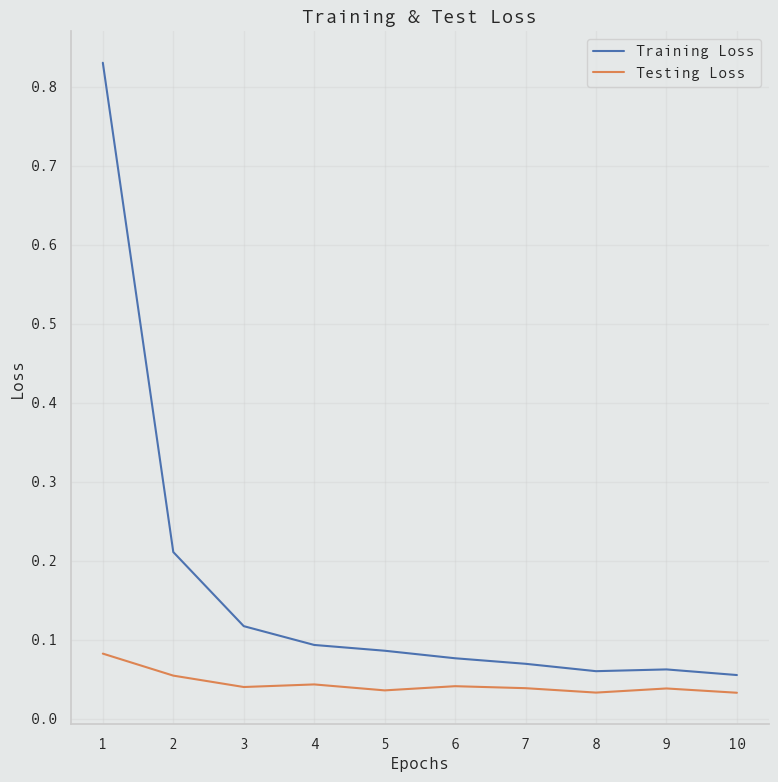

In [29]:
# Plot Training & Test Loss
figure, ax = plt.subplots(figsize=(9, 9))

sns.lineplot(
    data=model_metrics, 
    x=model_metrics.index.tolist(), 
    y='Training Loss', 
    label='Training Loss')

sns.lineplot(
    data=model_metrics, 
    x=model_metrics.index.tolist(), 
    y='Testing Loss', 
    label='Testing Loss')

ax.set_ylabel('Loss', 
              fontweight='bold')

ax.set_xlabel('Epochs', 
              fontweight='bold')

ax.set_title('Training & Test Loss', 
             fontsize=14)

plt.xticks(model_metrics.index.tolist())

plt.show()